In [39]:
# This script contains the optimization algorithms for improvement of the ranking
# by adjusting the weights for generic and specific landing pages

try:
    from sklearn.metrics import ndcg_score
    import numpy as np

    # import cma
    from pyswarm import pso
    # from openpyxl.utils import get_column_letter
except ModuleNotFoundError:
    # %pip install cma
    %pip install pyswarm 
    # %pip install openpyxl
    from sklearn.metrics import ndcg_score

    # import cma
    from pyswarm import pso
    # from openpyxl.utils import get_column_letter

import os
import pandas as pd
import numpy as np
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import requests
# import openpyxl
# from urllib.parse import urlparse, parse_qs, unquote

In [29]:
# Import test data set
# the file is located in the folder Ranking \\gruppende\umwelt.info\int\Zusammenarbeit\Ranking
# It was created as "ranking_test.xlsx" using metadata/notebooks/ranking_create_ranking_table_landpage.ipynb and then manually filled with human judged rankings ('ranking_test_landing_page_gesamt.xlsx').
df = pd.read_excel("ranking_test_landing_page_gesamt.xlsx")
session = requests.Session()

In [30]:
def fetch_scores(query, ids, landing_page_score):
    params = {
        "results_per_page": 100,
        "query": query,
        "quality_weight": 0.1875,
        "popularity_weight": 0.0625,
        "status_score": 0.6,  # This is not correct for "planned" and "under development" but due to them being very rare it was chosen like this for simplicity
        "landing_page_score": landing_page_score,
    }

    headers = {"accept": "application/json"}

    resp = session.get("http://localhost:8081/search", params=params, headers=headers)
    resp.raise_for_status()
    results = resp.json()

    scores = {f"{ds['source']}/{ds['id']}": ds["score"] for ds in results["results"]}
    return scores

In [31]:
def ndcg_loss(weights, df):
    ndcg_total = 0.0
    queries = df["query"].unique()

    for query in queries:
        query_df = df[df["query"] == query]
        relevant_df = query_df[query_df["ranking_mittelwert"] > 0]
        ids = relevant_df["id"].tolist()

        scores = fetch_scores(query, ids, landing_page_score=weights)
        pred_scores = np.array(
            [scores.get(id, 0.0) for id in relevant_df["id"]]
        ).reshape(1, -1)  # return 0 if id is not within the first 100 entries

        true_ranks = relevant_df["ranking_mittelwert"].values.reshape(1, -1)
        ndcg_total += ndcg_score(true_ranks, pred_scores)
    # Return the negative NDCG score for minimization
    return -ndcg_total

Iteration 0, Weight: 0.5, Loss: -9.692395738173468
Iteration 1, Weight: 0.5102040816326531, Loss: -9.69408299065255
Iteration 2, Weight: 0.5204081632653061, Loss: -9.695318670164983
Iteration 3, Weight: 0.5306122448979592, Loss: -9.710626127579449
Iteration 4, Weight: 0.5408163265306123, Loss: -9.710626127579449
Iteration 5, Weight: 0.5510204081632653, Loss: -9.720092928460732
Iteration 6, Weight: 0.5612244897959183, Loss: -9.737767932465216
Iteration 7, Weight: 0.5714285714285714, Loss: -9.737767932465216
Iteration 8, Weight: 0.5816326530612245, Loss: -9.749040052681952
Iteration 9, Weight: 0.5918367346938775, Loss: -9.750798117470037
Iteration 10, Weight: 0.6020408163265306, Loss: -9.752769607228865
Iteration 11, Weight: 0.6122448979591837, Loss: -9.752769607228865
Iteration 12, Weight: 0.6224489795918368, Loss: -9.761111577473429
Iteration 13, Weight: 0.6326530612244898, Loss: -9.76304330076235
Iteration 14, Weight: 0.6428571428571428, Loss: -9.77227913376925
Iteration 15, Weight: 0

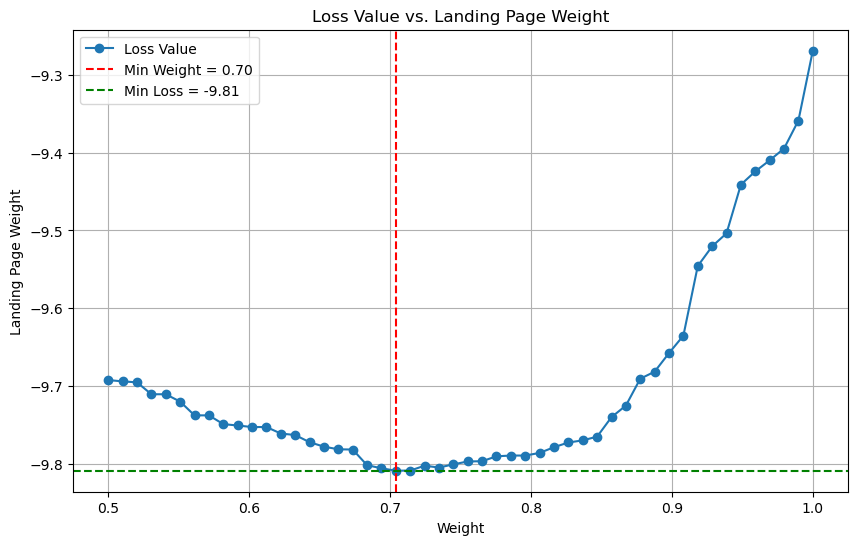

In [ ]:
# Method A: iterate over evenly spaced weight range to find optimum
a_values = np.linspace(0.5, 1, 50)

weights_list = []
loss_values_list = []
for i, a in enumerate(a_values):
    weights = a
    loss_value = ndcg_loss(weights, df)
    weights_list.append(weights)
    loss_values_list.append(loss_value)
    print(f"Iteration {i}, Weight: {weights}, Loss: {loss_value}")

min_loss_index = np.argmin(loss_values_list)
min_loss_value = loss_values_list[min_loss_index]
min_weight = weights_list[min_loss_index]

print("\nMinimum Loss and Corresponding Weight:")
print(f"Weight: {min_weight}, Loss: {min_loss_value}")

if not os.path.exists("Plots"):
    os.makedirs("Plots")

weights_array = np.array(weights_list)
loss_values_array = np.array(loss_values_list)

plt.figure(figsize=(10, 6))
plt.plot(weights_array, loss_values_array, marker="o", label="Loss Value")
plt.axvline(
    x=min_weight, color="r", linestyle="--", label=f"Min Weight = {min_weight:.2f}"
)
plt.axhline(
    y=min_loss_value,
    color="g",
    linestyle="--",
    label=f"Min Loss = {min_loss_value:.2f}",
)
plt.title("Loss Value vs. Landing Page Weight")
plt.xlabel("Weight")
plt.ylabel("Landing Page Weight")
plt.legend()
plt.grid(True)
plt.savefig("Plots/optimal_landing_page_weight.png")
plt.show()

In [34]:
# Method B: Particle Swarm Optimization (PSO)
def pso_ndcg_loss(weights, df):
    return ndcg_loss(weights, df)


# Define bounds for the weight (e.g., between 0.5 and 1)
lb = [0.5]  # Lower bound
ub = [1.0]  # Upper bound

# Optimize
opt_weight, opt_ndcg_loss = pso(
    pso_ndcg_loss,
    lb,
    ub,
    args=(df,),
    maxiter=30,
    minstep=1e-3,
    minfunc=1e-3,
    swarmsize=7,
)
print("Optimal Weight:", opt_weight)
print("Optimal Loss (Negative NDCG):", opt_ndcg_loss)

Stopping search: maximum iterations reached --> 30
Optimal Weight: [0.71151057]
Optimal Loss (Negative NDCG): -9.808939775875716


In [35]:
# Method C: Differential Evolution

# Define the wrapper for the ndcg_loss
def de_ndcg_loss(weights, df):
    return ndcg_loss(weights, df)


# Define bounds for the weights (assuming the weights are between 0 and 1)
bounds = [(0.5, 1)]  # Bounds for weights a, b

# Run Differential Evolution
result = differential_evolution(de_ndcg_loss, bounds, args=(df,))
opt_weights_c = result.x
print("Optimized weights:", opt_weights_c)

Optimized weights: [0.71406227]
